In [1]:
import sys
import os
import pathlib
import json
import pyvista as pv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


working_dir = pathlib.Path(os.path.abspath(""))
sys.path.append(str(working_dir.parents[1]))
from runs import find_runs  # noqa: E402

### Load data and calculate error

In [2]:
# The timestep we are interested in
timestep = 500

# Find the runs, we are interested in
runs = find_runs(working_dir)

# Load the data
data = {} # Raw data: {column: {grid_spacing: error_value}}

for run_path in runs:

    # Read parameters of the run
    with open(run_path / "parameters.json") as file:
        parameters = json.load(file) 

    # Generate descriptive column name
    column_name = {
        "nearest-neighbor": "NN",
        "rbf-pum-direct": "RBF",
    }[parameters["mapping"]]

    if parameters["mapping"] == "rbf-pum-direct":
        column_name += (
            "_"
            + {
                "compact-polynomial-c0": "CP0",
                "compact-polynomial-c2": "CP2",
                "compact-polynomial-c4": "CP4",
                "compact-polynomial-c6": "CP6",
                "compact-polynomial-c8": "CP8",
            }[parameters["basis_function"]]
        )
        column_name += f"_{parameters['support_radius']}"

    # Calculate grid spacing from refinement level
    grid_spacing = 1 / 2 ** parameters["refinement"]

    # Calculate error
    try:
        file_name = f"refinement-{parameters["refinement"]}_particles_{timestep:06}.pvtu"
        mesh = pv.read(run_path / "solution" / file_name)

        mesh["error"] = np.linalg.norm(mesh["velocity"] - mesh["analytical_velocity"], axis=1)

        mean_error = mesh["error"].mean()
    
    except FileNotFoundError:
        mean_error = np.nan

    # Insert error into data dict
    if column_name not in data:
        data[column_name] = {}
    data[column_name][grid_spacing] = mean_error

# Convert data dict to pandas DataFrame
df = pd.DataFrame(data).sort_index(axis=0, ascending=False).sort_index(axis=1)

df

,NN,RBF_CP0_0.5,RBF_CP2_0.5,RBF_CP4_0.5,RBF_CP6_0.5,RBF_CP8_0.5
1.000000,0.623162,0.623162,0.623162,0.623162,0.623162,0.623162
0.500000,0.623162,0.623162,0.623162,0.623162,0.623162,0.623162
0.250000,0.292588,0.334356,0.158313,0.257127,0.366756,0.454409
0.125000,0.130821,0.051556,0.010163,0.015477,0.018870,0.018866
0.062500,0.055805,0.014755,0.003208,0.003334,0.003364,0.003369
0.031250,0.025428,0.006320,0.003359,0.003347,0.003346,0.003345
0.015625,0.013372,0.004034,0.003351,0.003346,0.003345,0.003345
0.007812,0.007025,0.003502,0.003346,0.003345,0.003345,0.003345
0.003906,0.004410,0.003384,0.003345,0.003345,0.003345,0.003345
0.001953,0.003435,0.003355,0.003345,0.003345,0.003345,NaN


### Plot the error

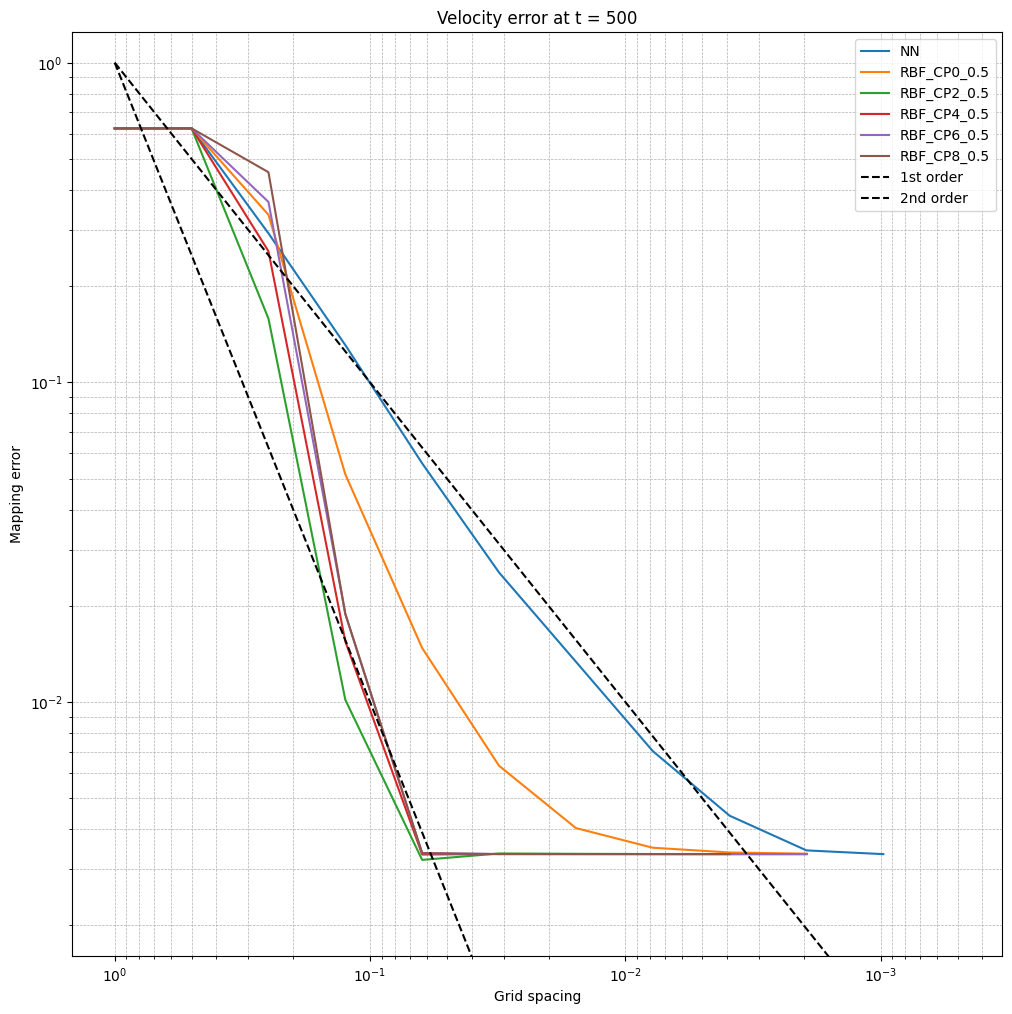

In [3]:
from pyparsing import line


def plot_error_convergence(data: pd.DataFrame, title: str, reference_lines = True):
    """Plot the velocity error at a given timestep over different grid resolutions.
    
    Args:
        data: A DataFrame containing the error data. The index should be the grid
            resolution. Each column will be plotted as a separate line. 
        timestep: Timestep to plot.
        title: Title of the plot.
        reference_lines: If True, plot reference lines for first and second order
            convergence.
    """

    # Set up the plot
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 12)

    # Plot the data
    for column in data.columns:
        ax.plot(data.index, data[column], label=column)
    
    # Plot reference lines
    if reference_lines:
        # First order convergence
        ax.plot(data.index, data.index, linestyle="--", color="black", label="1st order")
        # Second order convergence
        ax.plot(data.index, data.index ** 2, linestyle="--", color="black", label="2nd order")

    # Add labels and legend
    ax.set_title(title)
    ax.legend()
    ax.grid(which="both", linestyle="--", linewidth=0.5)

    # Configure axes
    ax.set_xlabel("Grid spacing")
    ax.set_xscale("log")
    ax.invert_xaxis()
    
    ax.set_ylabel("Mapping error")
    ax.set_yscale("log")
    ax.set_ylim(data.min().min() / 2, data.max().max() * 2)

plot_error_convergence(df, title="Velocity error at t = 500")
plt.show()